# 🚗 Road Pothole Detection from Dash Cam
## YOLOv8 Object Detection for Raspberry Pi Zero with MotionEyeOS

**Dataset:** [Potholes Dataset for Potholes Detection](https://www.kaggle.com/datasets/omaraakl/potholes-dataset-for-potholes-detection)

**Goal:** Train a lightweight pothole detection model deployable on Raspberry Pi Zero

### 📋 Table of Contents
1. Setup and Installation
2. Data Exploration and Analysis
3. Data Preparation
4. Model Training (YOLOv8)
5. Model Evaluation
6. Export for Raspberry Pi
7. Deployment Instructions

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install ultralytics==8.0.196
!pip install opencv-python-headless
!pip install matplotlib seaborn
!pip install pillow
!pip install pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 14.0 MB/s eta 0:00:0000:01


In [2]:
# Import libraries
import os
import yaml
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Exploration and Analysis

In [3]:
# Define paths - adjust these based on your Kaggle dataset mounting
DATASET_PATH = '/kaggle/input/potholes-dataset-for-potholes-detection'
OUTPUT_PATH = '/kaggle/working'

# Create working directories
os.makedirs(f'{OUTPUT_PATH}/dataset', exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}/runs', exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print("\n📁 Dataset structure:")
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Only show first 2 levels
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

Dataset path: /kaggle/input/potholes-dataset-for-potholes-detection
Output path: /kaggle/working

📁 Dataset structure:
potholes-dataset-for-potholes-detection/
  Potholes Detector YOLO26/
    valid/
      labels/
      images/
    test/
      labels/
      images/
    train/
      labels/
      images/


In [4]:
# Analyze dataset structure and count files
def analyze_dataset(dataset_path):
    stats = {
        'train_images': 0,
        'train_labels': 0,
        'valid_images': 0,
        'valid_labels': 0,
        'test_images': 0,
        'test_labels': 0
    }
    
    # Count files in each directory
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(dataset_path, split, 'images')
        lbl_dir = os.path.join(dataset_path, split, 'labels')
        
        if os.path.exists(img_dir):
            stats[f'{split}_images'] = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        if os.path.exists(lbl_dir):
            stats[f'{split}_labels'] = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])
    
    return stats

# Define paths - adjust these based on your Kaggle dataset mounting
DATASET_BASE = '/kaggle/input/potholes-dataset-for-potholes-detection'
DATASET_PATH = os.path.join(DATASET_BASE, 'Potholes Detector YOLO26')

stats = analyze_dataset(DATASET_PATH)

print("\n📊 Dataset Statistics:")
print("=" * 50)
print(f"Training Set:   {stats['train_images']:>5} images | {stats['train_labels']:>5} labels")
print(f"Validation Set: {stats['valid_images']:>5} images | {stats['valid_labels']:>5} labels")
print(f"Test Set:       {stats['test_images']:>5} images | {stats['test_labels']:>5} labels")
print("=" * 50)
print(f"Total:          {sum([stats['train_images'], stats['valid_images'], stats['test_images']]):>5} images")


📊 Dataset Statistics:
Training Set:     999 images |   998 labels
Validation Set:   133 images |   134 labels
Test Set:          59 images |    60 labels
Total:           1191 images


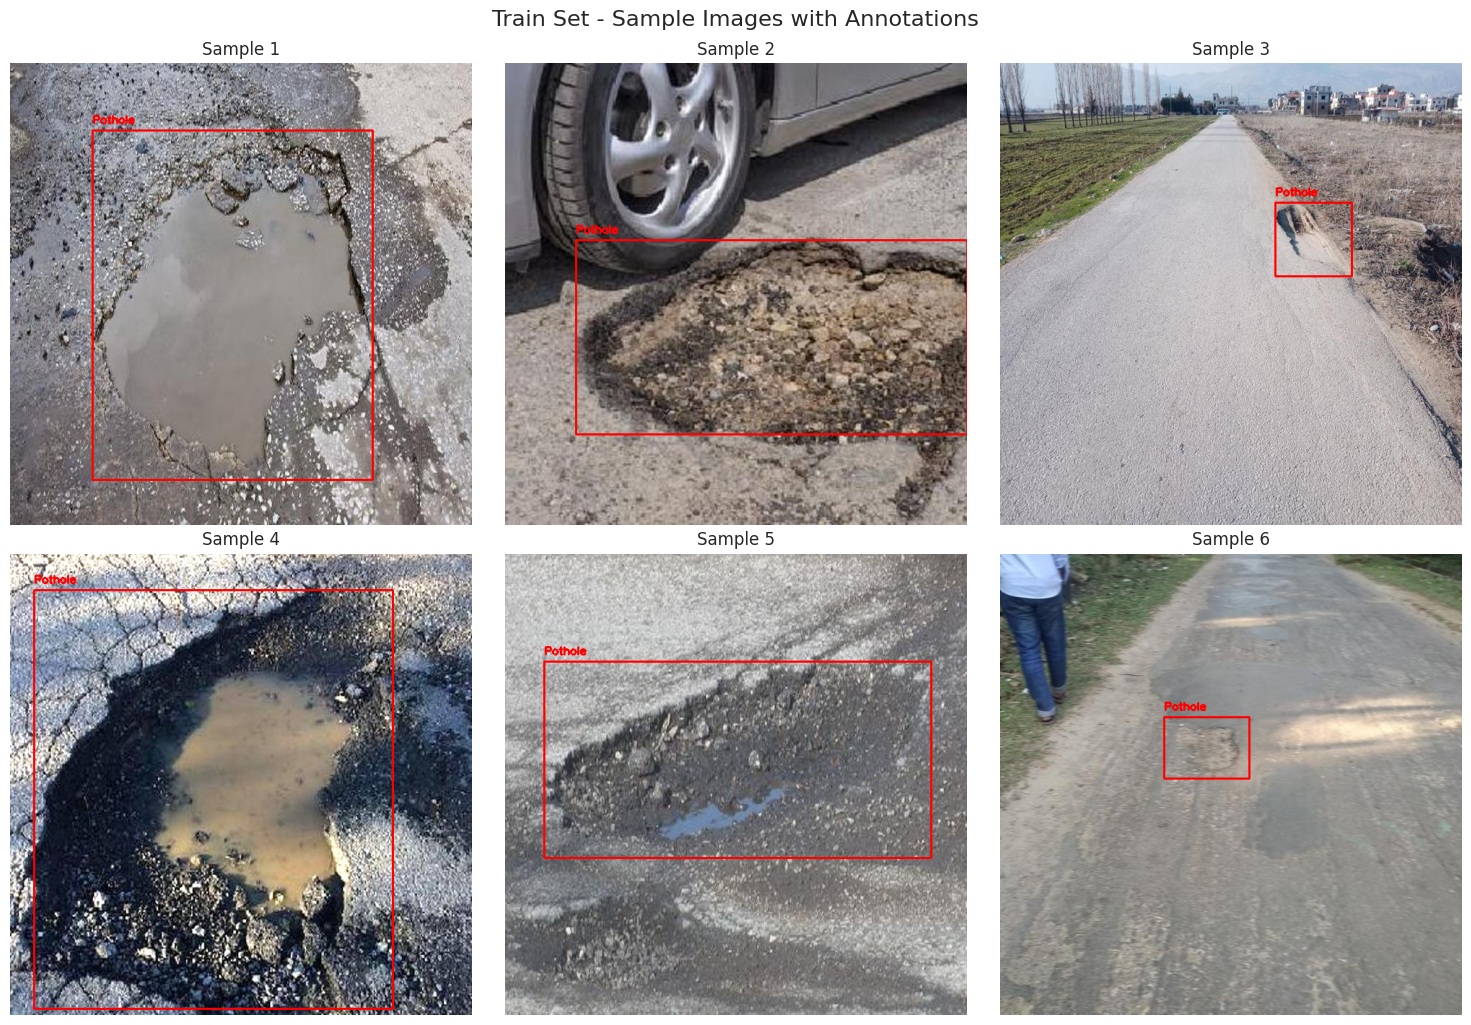

In [5]:
# Visualize sample images with annotations
def visualize_samples(dataset_path, split='train', num_samples=6):
    img_dir = os.path.join(dataset_path, split, 'images')
    lbl_dir = os.path.join(dataset_path, split, 'labels')
    
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:num_samples]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(image_files):
        # Read image
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Read label
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(lbl_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                annotations = f.readlines()
            
            # Draw bounding boxes
            for ann in annotations:
                parts = ann.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, 'Pothole', (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Sample {idx+1}')
    
    plt.tight_layout()
    plt.suptitle(f'{split.capitalize()} Set - Sample Images with Annotations', y=1.02, fontsize=16)
    plt.show()

visualize_samples(DATASET_PATH, 'train', 6)

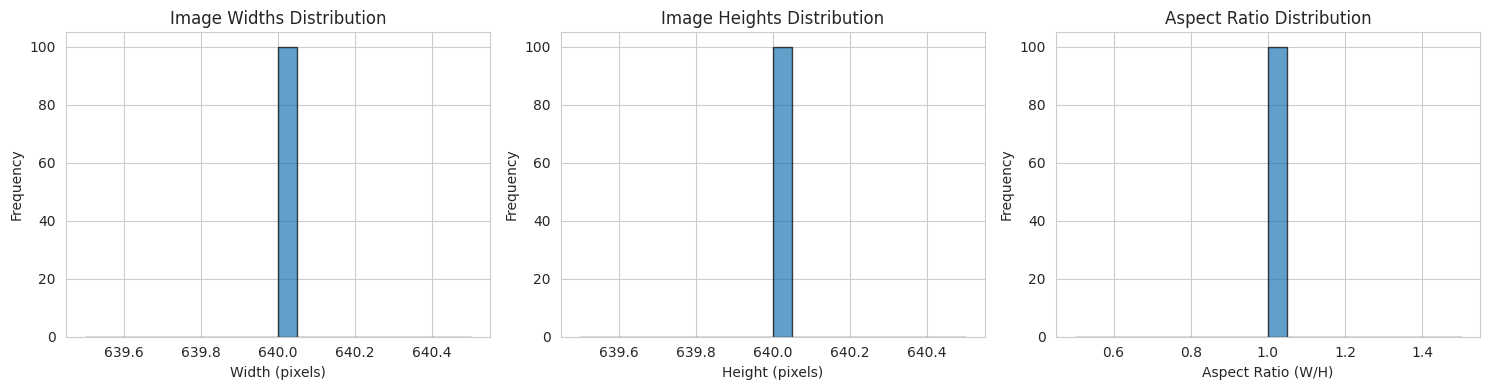


📏 Image Statistics (from 100 samples):
Average size: 640 x 640
Min size: 640 x 640
Max size: 640 x 640
Average aspect ratio: 1.00


In [6]:
# Analyze image sizes and aspect ratios
def analyze_image_properties(dataset_path, split='train', sample_size=100):
    img_dir = os.path.join(dataset_path, split, 'images')
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:sample_size]
    
    widths, heights, aspect_ratios = [], [], []
    
    for img_file in image_files:
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(widths, bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_title('Image Widths Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(heights, bins=20, edgecolor='black', alpha=0.7)
    axes[1].set_title('Image Heights Distribution')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    
    axes[2].hist(aspect_ratios, bins=20, edgecolor='black', alpha=0.7)
    axes[2].set_title('Aspect Ratio Distribution')
    axes[2].set_xlabel('Aspect Ratio (W/H)')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📏 Image Statistics (from {sample_size} samples):")
    print(f"Average size: {np.mean(widths):.0f} x {np.mean(heights):.0f}")
    print(f"Min size: {np.min(widths):.0f} x {np.min(heights):.0f}")
    print(f"Max size: {np.max(widths):.0f} x {np.max(heights):.0f}")
    print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")

analyze_image_properties(DATASET_PATH, 'train', 100)

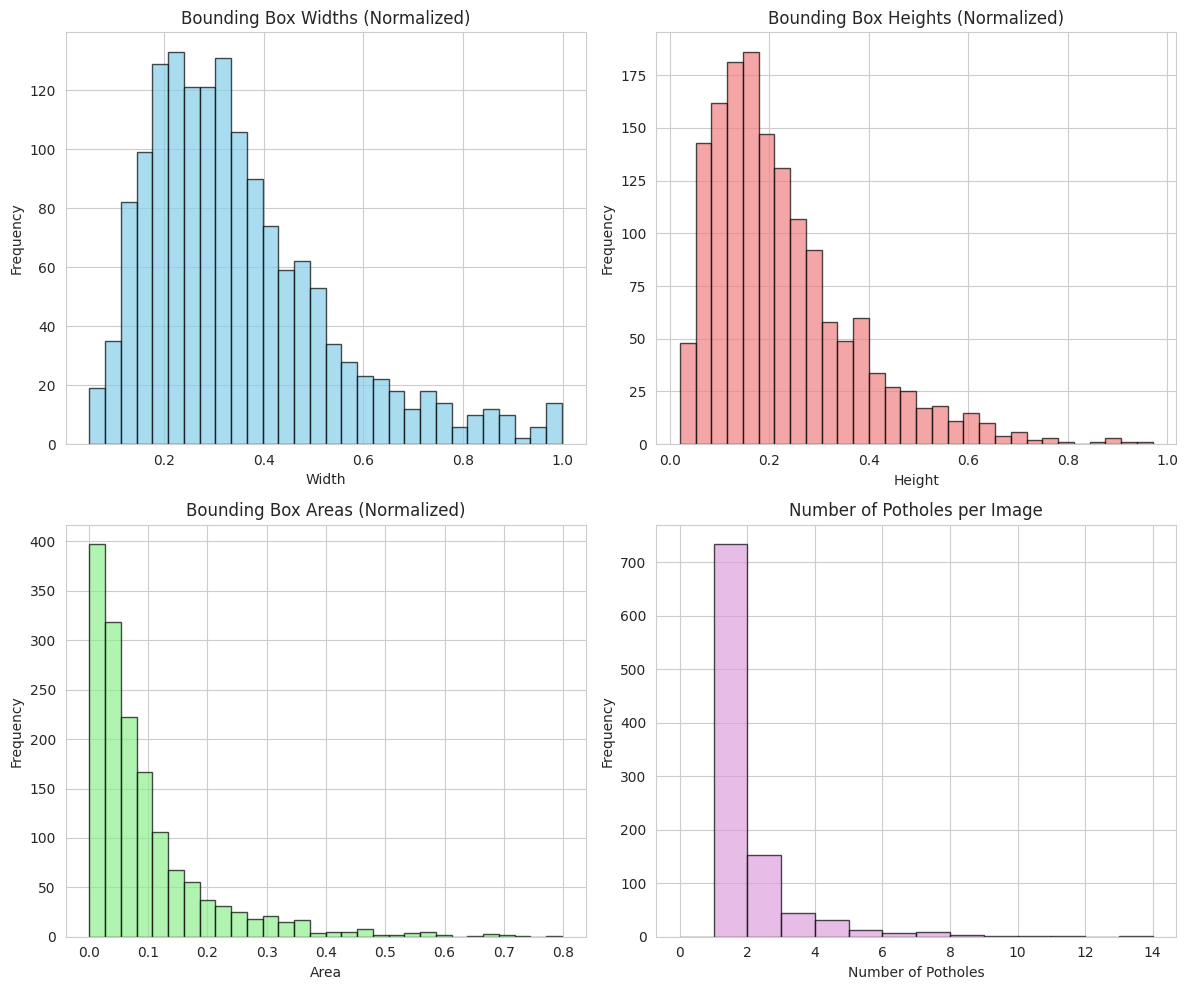


📦 Bounding Box Statistics:
Total annotations: 1543
Avg potholes per image: 1.55
Avg bbox size: 0.349 x 0.226
Avg bbox area: 0.0960


In [7]:
# Analyze bounding box statistics
def analyze_bbox_stats(dataset_path, split='train'):
    lbl_dir = os.path.join(dataset_path, split, 'labels')
    label_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]
    
    bbox_widths, bbox_heights, bbox_areas = [], [], []
    num_objects_per_image = []
    
    for lbl_file in label_files:
        lbl_path = os.path.join(lbl_dir, lbl_file)
        with open(lbl_path, 'r') as f:
            annotations = f.readlines()
        
        num_objects_per_image.append(len(annotations))
        
        for ann in annotations:
            parts = ann.strip().split()
            if len(parts) == 5:
                _, _, _, width, height = map(float, parts)
                bbox_widths.append(width)
                bbox_heights.append(height)
                bbox_areas.append(width * height)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].hist(bbox_widths, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Bounding Box Widths (Normalized)')
    axes[0, 0].set_xlabel('Width')
    axes[0, 0].set_ylabel('Frequency')
    
    axes[0, 1].hist(bbox_heights, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Bounding Box Heights (Normalized)')
    axes[0, 1].set_xlabel('Height')
    axes[0, 1].set_ylabel('Frequency')
    
    axes[1, 0].hist(bbox_areas, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[1, 0].set_title('Bounding Box Areas (Normalized)')
    axes[1, 0].set_xlabel('Area')
    axes[1, 0].set_ylabel('Frequency')
    
    axes[1, 1].hist(num_objects_per_image, bins=range(0, max(num_objects_per_image)+2), 
                    edgecolor='black', alpha=0.7, color='plum')
    axes[1, 1].set_title('Number of Potholes per Image')
    axes[1, 1].set_xlabel('Number of Potholes')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📦 Bounding Box Statistics:")
    print(f"Total annotations: {len(bbox_widths)}")
    print(f"Avg potholes per image: {np.mean(num_objects_per_image):.2f}")
    print(f"Avg bbox size: {np.mean(bbox_widths):.3f} x {np.mean(bbox_heights):.3f}")
    print(f"Avg bbox area: {np.mean(bbox_areas):.4f}")

analyze_bbox_stats(DATASET_PATH, 'train')

## 3. Data Preparation for YOLOv8

In [8]:
# Create YAML configuration file for YOLOv8
yaml_content = {
    'path': DATASET_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 1,  # number of classes
    'names': ['pothole']  # class names
}

yaml_path = f'{OUTPUT_PATH}/pothole_data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print("✅ YAML configuration created!")
print(f"\nConfiguration:")
with open(yaml_path, 'r') as f:
    print(f.read())

✅ YAML configuration created!

Configuration:
path: /kaggle/input/potholes-dataset-for-potholes-detection/Potholes Detector YOLO26
train: train/images
val: valid/images
test: test/images
nc: 1
names:
- pothole



## 4. Model Training

We'll use YOLOv8 Nano (yolov8n) which is the smallest and fastest model, perfect for Raspberry Pi Zero.

In [9]:
# Initialize YOLOv8n model (nano - smallest version)
# Fix for PyTorch 2.6+ weights_only issue
from ultralytics import YOLO
import torch

print("🔄 Loading YOLOv8 Nano model...")

# Method 1: Patch torch.load before importing ultralytics modules
import torch.serialization

# Store the original torch.load function
_original_torch_load = torch.load.__wrapped__ if hasattr(torch.load, '__wrapped__') else torch.load

def patched_torch_load(*args, **kwargs):
    # Force weights_only=False for all torch.load calls
    kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)

# Apply the patch
torch.load = patched_torch_load

# Now load the model
try:
    model = YOLO('yolov8n.pt')  # Use nano model for lightweight deployment
    print("✅ YOLOv8 Nano model loaded!")
except Exception as e:
    print(f"⚠️ Error: {e}")
    print("🔄 Downloading fresh YOLOv8n weights...")
    import urllib.request
    url = 'https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8n.pt'
    urllib.request.urlretrieve(url, 'yolov8n.pt')
    model = YOLO('yolov8n.pt')
    print("✅ YOLOv8 Nano model loaded!")

print("\nModel Summary:")
model.info()

🔄 Loading YOLOv8 Nano model...


100%|██████████| 6.23M/6.23M [00:00<00:00, 125MB/s]
YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


✅ YOLOv8 Nano model loaded!

Model Summary:


(225, 3157200, 0, 8.8575488)

In [ ]:
# Train the model with progress display fix
import torch
import sys

# Force stdout to flush immediately (fix for Kaggle notebooks)
sys.stdout.flush()

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️  Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

sys.stdout.flush()

# Reduce epochs for testing to see if it works
results = model.train(
    data=yaml_path,
    epochs=20,  # Reduced for testing - increase later
    patience=10,
    batch=32,
    imgsz=416,
    save=True,
    save_period=5,
    cache=False,  # Disable cache to see progress immediately
    device=device,
    workers=4,  # Reduce workers to avoid blocking
    project='runs',
    name='pothole_detector',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    # Learning rate
    lr0=0.001,
    lrf=0.01,
    # Augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
)

print("\n✅ Training completed!")

🖥️  Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.89 GB


New https://pypi.org/project/ultralytics/8.4.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/pothole_data.yaml, epochs=20, patience=10, batch=32, imgsz=416, save=True, save_period=5, cache=False, device=cuda, workers=4, project=runs, name=pothole_detector, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visuali

<IPython.core.display.Javascript object>

## 5. Model Evaluation

In [ ]:
# Load best model
best_model = YOLO(f'{OUTPUT_PATH}/runs/pothole_detector/weights/best.pt')

# Validate on test set
metrics = best_model.val(
    data=yaml_path,
    split='test',
    imgsz=416
)

print("\n📊 Test Set Metrics:")
print("=" * 50)
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall:    {metrics.box.mr:.4f}")
print(f"mAP@50:    {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")
print("=" * 50)

In [ ]:
# Display training results
from IPython.display import Image as IPImage

results_path = f'{OUTPUT_PATH}/runs/pothole_detector'

print("📈 Training Results:")
print("\n1. Training Metrics:")
display(IPImage(filename=f'{results_path}/results.png', width=900))

print("\n2. Confusion Matrix:")
display(IPImage(filename=f'{results_path}/confusion_matrix.png', width=600))

print("\n3. Prediction Examples:")
display(IPImage(filename=f'{results_path}/val_batch0_pred.jpg', width=900))

In [ ]:
# Test on sample images
test_img_dir = os.path.join(DATASET_PATH, 'test', 'images')
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))][:6]

# Run inference
results = best_model.predict(
    source=test_images,
    imgsz=416,
    conf=0.25,  # Confidence threshold
    save=True,
    project=f'{OUTPUT_PATH}/predictions',
    name='test_samples'
)

# Display predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

pred_dir = f'{OUTPUT_PATH}/predictions/test_samples'
pred_images = sorted([f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))])[:6]

for idx, img_file in enumerate(pred_images):
    img = Image.open(os.path.join(pred_dir, img_file))
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Prediction {idx+1}')

plt.tight_layout()
plt.suptitle('Model Predictions on Test Images', y=1.02, fontsize=16)
plt.show()

## 6. Export for Raspberry Pi Zero

For Raspberry Pi Zero, we need to export the model to a lightweight format.

In [ ]:
# Export model for edge deployment
print("🔄 Exporting model for Raspberry Pi...\n")

# Export to ONNX format (more compatible with various deployment scenarios)
onnx_path = best_model.export(
    format='onnx',
    imgsz=416,
    simplify=True,
    dynamic=False
)
print(f"✅ ONNX model exported: {onnx_path}")

# Also keep PyTorch format for native inference
pt_path = f'{OUTPUT_PATH}/runs/pothole_detector/weights/best.pt'
print(f"✅ PyTorch model available: {pt_path}")

# Get model size
import os
pt_size = os.path.getsize(pt_path) / (1024 * 1024)
onnx_size = os.path.getsize(onnx_path) / (1024 * 1024)

print(f"\n📦 Model Sizes:")
print(f"PyTorch (.pt):  {pt_size:.2f} MB")
print(f"ONNX (.onnx):   {onnx_size:.2f} MB")

In [ ]:
# Benchmark inference speed
import time

test_image = test_images[0]
img = Image.open(test_image)
img = img.resize((416, 416))

# Warm up
for _ in range(5):
    _ = best_model.predict(test_image, imgsz=416, verbose=False)

# Benchmark
times = []
for _ in range(20):
    start = time.time()
    _ = best_model.predict(test_image, imgsz=416, verbose=False)
    times.append(time.time() - start)

avg_time = np.mean(times) * 1000  # Convert to ms
fps = 1000 / avg_time

print(f"\n⚡ Inference Benchmark (on current hardware):")
print(f"Average inference time: {avg_time:.2f} ms")
print(f"Estimated FPS: {fps:.2f}")
print(f"\n⚠️  Note: Raspberry Pi Zero will be significantly slower (expect 1-3 FPS)")

## 7. Raspberry Pi Deployment Guide

### Hardware Requirements:
- Raspberry Pi Zero W/WH (with WiFi)
- Raspberry Pi Camera Module or USB Camera
- MicroSD Card (16GB+ recommended)
- Power Supply (5V, 2.5A recommended)

### Software Setup Steps:

#### 1. Install MotionEyeOS
```bash
# Download MotionEyeOS image for Raspberry Pi Zero
# Flash to SD card using Raspberry Pi Imager or Etcher
# Insert SD card and boot Raspberry Pi
```

#### 2. Setup Python Environment on Raspberry Pi
```bash
# SSH into your Raspberry Pi
ssh root@<your-pi-ip>

# Update system
apt-get update
apt-get upgrade -y

# Install dependencies
apt-get install python3-pip python3-opencv libopencv-dev -y
pip3 install --upgrade pip

# Install ultralytics (lightweight)
pip3 install ultralytics opencv-python-headless pillow
```

#### 3. Transfer Model to Raspberry Pi
```bash
# On your local machine, copy the model
scp best.pt root@<your-pi-ip>:/root/pothole_model.pt
```

#### 4. Create Inference Script
See the next cell for the deployment script.

In [ ]:
# Create deployment script for Raspberry Pi
deployment_script = '''#!/usr/bin/env python3
"""
Pothole Detection Script for Raspberry Pi Zero with MotionEyeOS
This script captures frames from the camera and runs pothole detection.
"""

import cv2
import numpy as np
from ultralytics import YOLO
import time
import argparse
from datetime import datetime
import os

class PotholeDetector:
    def __init__(self, model_path, camera_source=0, conf_threshold=0.25):
        """
        Initialize pothole detector
        
        Args:
            model_path: Path to YOLO model (.pt file)
            camera_source: Camera device index or RTSP stream URL
            conf_threshold: Confidence threshold for detections
        """
        print("Loading model...")
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold
        self.camera_source = camera_source
        self.cap = None
        
        # Create output directory for detections
        self.output_dir = "/root/pothole_detections"
        os.makedirs(self.output_dir, exist_ok=True)
        
        print("Model loaded successfully!")
    
    def initialize_camera(self):
        """Initialize camera capture"""
        print(f"Initializing camera: {self.camera_source}")
        self.cap = cv2.VideoCapture(self.camera_source)
        
        if not self.cap.isOpened():
            raise RuntimeError("Failed to open camera")
        
        # Set camera properties for optimal performance on RPi Zero
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 416)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 416)
        self.cap.set(cv2.CAP_PROP_FPS, 10)
        
        print("Camera initialized!")
    
    def detect_potholes(self, frame):
        """
        Run pothole detection on a frame
        
        Args:
            frame: Input image frame
            
        Returns:
            annotated_frame: Frame with bounding boxes
            detections: List of detection dictionaries
        """
        results = self.model.predict(
            source=frame,
            imgsz=416,
            conf=self.conf_threshold,
            verbose=False
        )
        
        annotated_frame = results[0].plot()
        
        # Extract detection information
        detections = []
        boxes = results[0].boxes
        
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            
            detections.append({
                'bbox': [int(x1), int(y1), int(x2), int(y2)],
                'confidence': conf,
                'class': cls
            })
        
        return annotated_frame, detections
    
    def save_detection(self, frame, detections):
        """Save frame when pothole is detected"""
        if len(detections) > 0:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"pothole_{timestamp}.jpg"
            filepath = os.path.join(self.output_dir, filename)
            cv2.imwrite(filepath, frame)
            print(f"Pothole detected! Saved to {filepath}")
    
    def run(self, save_detections=True, display=False):
        """
        Main detection loop
        
        Args:
            save_detections: Whether to save images with detections
            display: Whether to display video (requires X server)
        """
        self.initialize_camera()
        
        fps_counter = []
        frame_count = 0
        
        print("Starting pothole detection...")
        print("Press Ctrl+C to stop")
        
        try:
            while True:
                ret, frame = self.cap.read()
                if not ret:
                    print("Failed to grab frame")
                    break
                
                start_time = time.time()
                
                # Run detection
                annotated_frame, detections = self.detect_potholes(frame)
                
                # Calculate FPS
                fps = 1 / (time.time() - start_time)
                fps_counter.append(fps)
                
                # Display FPS on frame
                cv2.putText(annotated_frame, f"FPS: {fps:.1f}", 
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                           0.7, (0, 255, 0), 2)
                
                # Save detection if enabled
                if save_detections:
                    self.save_detection(annotated_frame, detections)
                
                # Display frame if enabled
                if display:
                    cv2.imshow('Pothole Detection', annotated_frame)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                
                frame_count += 1
                
                # Print statistics every 30 frames
                if frame_count % 30 == 0:
                    avg_fps = np.mean(fps_counter[-30:])
                    print(f"Frame {frame_count} | Avg FPS: {avg_fps:.2f} | Detections: {len(detections)}")
        
        except KeyboardInterrupt:
            print("\nStopping detection...")
        
        finally:
            self.cleanup()
    
    def cleanup(self):
        """Release resources"""
        if self.cap is not None:
            self.cap.release()
        cv2.destroyAllWindows()
        print("Cleanup complete")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Pothole Detection for Raspberry Pi")
    parser.add_argument("--model", type=str, default="/root/pothole_model.pt",
                       help="Path to YOLO model")
    parser.add_argument("--camera", type=str, default="0",
                       help="Camera source (0 for USB cam, or RTSP URL for MotionEye stream)")
    parser.add_argument("--conf", type=float, default=0.25,
                       help="Confidence threshold")
    parser.add_argument("--no-save", action="store_true",
                       help="Don't save detected potholes")
    parser.add_argument("--display", action="store_true",
                       help="Display video feed (requires X server)")
    
    args = parser.parse_args()
    
    # Convert camera argument
    camera_source = int(args.camera) if args.camera.isdigit() else args.camera
    
    # Initialize and run detector
    detector = PotholeDetector(
        model_path=args.model,
        camera_source=camera_source,
        conf_threshold=args.conf
    )
    
    detector.run(
        save_detections=not args.no_save,
        display=args.display
    )
'''

# Save deployment script
script_path = f'{OUTPUT_PATH}/pothole_detection_rpi.py'
with open(script_path, 'w') as f:
    f.write(deployment_script)

print("✅ Deployment script created!")
print(f"Script saved to: {script_path}")
print("\n📝 Usage on Raspberry Pi:")
print("python3 pothole_detection_rpi.py --model /root/pothole_model.pt --camera 0")

In [ ]:
# Create systemd service file for auto-start
service_file = '''[Unit]
Description=Pothole Detection Service
After=network.target

[Service]
Type=simple
User=root
WorkingDirectory=/root
ExecStart=/usr/bin/python3 /root/pothole_detection_rpi.py --model /root/pothole_model.pt --camera 0
Restart=on-failure
RestartSec=10

[Install]
WantedBy=multi-user.target
'''

service_path = f'{OUTPUT_PATH}/pothole-detector.service'
with open(service_path, 'w') as f:
    f.write(service_file)

print("✅ Systemd service file created!")
print(f"Service file saved to: {service_path}")
print("\n📝 To enable auto-start on Raspberry Pi:")
print("sudo cp pothole-detector.service /etc/systemd/system/")
print("sudo systemctl daemon-reload")
print("sudo systemctl enable pothole-detector.service")
print("sudo systemctl start pothole-detector.service")

In [ ]:
# Create README for deployment
readme_content = '''# Pothole Detection System - Raspberry Pi Deployment Guide

## 📋 Overview
This system uses YOLOv8 Nano to detect potholes from a dash cam mounted on a Raspberry Pi Zero running MotionEyeOS.

## 🔧 Hardware Requirements
- Raspberry Pi Zero W/WH
- Raspberry Pi Camera Module or USB Camera
- MicroSD Card (16GB minimum, 32GB recommended)
- 5V 2.5A Power Supply
- Dash cam mount (optional)

## 📦 Files Included
- `pothole_model.pt` - Trained YOLOv8 Nano model
- `pothole_detection_rpi.py` - Detection script
- `pothole-detector.service` - Systemd service for auto-start
- `README.md` - This file

## 🚀 Installation Steps

### 1. Setup MotionEyeOS
```bash
# Download MotionEyeOS for Raspberry Pi Zero
# https://github.com/motioneye-project/motioneyeos/releases

# Flash to SD card using:
# - Raspberry Pi Imager (recommended)
# - Etcher
# - dd command

# Insert SD card and boot Raspberry Pi
# Connect via web interface at http://<pi-ip>:8765
```

### 2. SSH Setup
```bash
# Enable SSH in MotionEyeOS settings or create empty 'ssh' file in boot partition

# SSH into Raspberry Pi (default password: blank)
ssh root@<your-pi-ip>
```

### 3. Install Dependencies
```bash
# Update system
mount -o remount,rw /
mount -o remount,rw /boot

apt-get update
apt-get upgrade -y

# Install Python and OpenCV
apt-get install -y python3-pip python3-opencv libopencv-dev \
                   libatlas-base-dev libjpeg-dev libpng-dev

# Upgrade pip
pip3 install --upgrade pip

# Install ultralytics (this may take a while on RPi Zero)
pip3 install ultralytics opencv-python-headless pillow numpy
```

### 4. Transfer Model and Scripts
```bash
# From your local machine
scp pothole_model.pt root@<pi-ip>:/root/
scp pothole_detection_rpi.py root@<pi-ip>:/root/
scp pothole-detector.service root@<pi-ip>:/root/

# On Raspberry Pi, make script executable
chmod +x /root/pothole_detection_rpi.py
```

### 5. Test Detection
```bash
# Run manual test
cd /root
python3 pothole_detection_rpi.py --model pothole_model.pt --camera 0

# Test with MotionEye stream (if configured)
python3 pothole_detection_rpi.py --model pothole_model.pt \
  --camera "rtsp://localhost:8554/stream"
```

### 6. Setup Auto-Start (Optional)
```bash
# Copy service file
cp /root/pothole-detector.service /etc/systemd/system/

# Enable and start service
systemctl daemon-reload
systemctl enable pothole-detector.service
systemctl start pothole-detector.service

# Check status
systemctl status pothole-detector.service

# View logs
journalctl -u pothole-detector.service -f
```

## 📊 Performance Expectations
- **Raspberry Pi Zero**: 1-3 FPS (inference only)
- **Raspberry Pi 3/4**: 5-10 FPS
- **With Coral USB Accelerator**: 15-25 FPS

## ⚙️ Configuration Options

### Command Line Arguments
```bash
python3 pothole_detection_rpi.py --help

Options:
  --model PATH       Path to YOLO model (default: /root/pothole_model.pt)
  --camera SOURCE    Camera source: 0 for USB, RTSP URL for stream
  --conf FLOAT       Confidence threshold (default: 0.25)
  --no-save          Don't save detected potholes
  --display          Display video feed (requires X server)
```

### Camera Sources
```bash
# USB Camera
--camera 0

# Raspberry Pi Camera (via MotionEye)
--camera "rtsp://localhost:8554/stream"

# External IP Camera
--camera "rtsp://192.168.1.100:554/stream"
```

## 📁 Output Files
Detected potholes are saved to `/root/pothole_detections/`:
```
pothole_detections/
├── pothole_20260131_143022.jpg
├── pothole_20260131_143145.jpg
└── ...
```

## 🔍 Troubleshooting

### Camera Not Found
```bash
# List video devices
ls -l /dev/video*

# Test camera with v4l2
v4l2-ctl --list-devices
```

### Low FPS
- Reduce image size in script (change `imgsz=416` to `imgsz=320`)
- Increase confidence threshold (reduces false positives)
- Consider upgrading to Raspberry Pi 3/4
- Use Coral USB Accelerator for hardware acceleration

### Out of Memory
```bash
# Increase swap size
dphys-swapfile swapoff
nano /etc/dphys-swapfile  # Set CONF_SWAPSIZE=1024
dphys-swapfile setup
dphys-swapfile swapon
```

### Model Loading Error
```bash
# Verify model file
ls -lh /root/pothole_model.pt

# Test model loading
python3 -c "from ultralytics import YOLO; YOLO('/root/pothole_model.pt')"
```

## 🎯 Optimization Tips

### For Better Performance
1. **Reduce Resolution**: Lower input size improves FPS
2. **Skip Frames**: Process every Nth frame instead of all frames
3. **Increase Confidence**: Higher threshold = fewer false positives
4. **Use Hardware Acceleration**: Consider Coral TPU or Intel NCS2

### For Better Accuracy
1. **Lower Confidence**: Catches more potholes but increases false positives
2. **Higher Resolution**: Better detection but slower
3. **Retrain Model**: Add more images from your specific camera/conditions

## 📞 Support & Resources
- MotionEyeOS: https://github.com/motioneye-project/motioneyeos
- Ultralytics YOLOv8: https://docs.ultralytics.com/
- Raspberry Pi Forums: https://www.raspberrypi.org/forums/

## 📄 License
This project uses YOLOv8 (AGPL-3.0 license). For commercial use, consider Ultralytics Enterprise License.

## 🤝 Contributing
Feel free to improve the model by:
- Adding more training data
- Fine-tuning hyperparameters
- Implementing post-processing filters
- Adding GPS logging for pothole locations

---
**Note**: Raspberry Pi Zero has limited processing power. For real-time applications, consider using Raspberry Pi 4 or adding hardware acceleration.
'''

readme_path = f'{OUTPUT_PATH}/DEPLOYMENT_README.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)

print("✅ Deployment README created!")
print(f"README saved to: {readme_path}")

## 📦 Package Everything for Download

In [ ]:
# Create deployment package
import zipfile

deployment_dir = f'{OUTPUT_PATH}/pothole_detector_deployment'
os.makedirs(deployment_dir, exist_ok=True)

# Copy files to deployment directory
files_to_package = [
    (f'{OUTPUT_PATH}/runs/pothole_detector/weights/best.pt', 'pothole_model.pt'),
    (f'{OUTPUT_PATH}/pothole_detection_rpi.py', 'pothole_detection_rpi.py'),
    (f'{OUTPUT_PATH}/pothole-detector.service', 'pothole-detector.service'),
    (f'{OUTPUT_PATH}/DEPLOYMENT_README.md', 'README.md'),
]

for src, dst in files_to_package:
    if os.path.exists(src):
        shutil.copy(src, os.path.join(deployment_dir, dst))

# Create zip file
zip_path = f'{OUTPUT_PATH}/pothole_detector_rpi.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(deployment_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, deployment_dir)
            zipf.write(file_path, arcname)

print("✅ Deployment package created!")
print(f"\n📦 Package location: {zip_path}")
print(f"Package size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
print("\n📋 Package contents:")
for src, dst in files_to_package:
    if os.path.exists(src):
        print(f"  ✓ {dst}")

## 🎉 Summary

### What We Built:
1. ✅ Trained YOLOv8 Nano model for pothole detection
2. ✅ Created deployment script for Raspberry Pi Zero
3. ✅ Packaged everything for easy deployment
4. ✅ Provided comprehensive documentation

### Next Steps:
1. Download the deployment package (`pothole_detector_rpi.zip`)
2. Follow the README instructions to deploy on your Raspberry Pi Zero
3. Test the system and adjust confidence threshold as needed
4. Consider adding GPS logging to map pothole locations

### Performance Notes:
- **Training Accuracy**: Check the metrics above
- **Expected FPS on RPi Zero**: 1-3 FPS
- **Model Size**: ~6 MB (YOLOv8 Nano)
- **Recommended**: Use Raspberry Pi 3/4 for better performance

### Potential Improvements:
1. Add GPS module to log pothole locations
2. Implement cloud upload for detections
3. Add notification system (email/SMS) for detected potholes
4. Create web dashboard to visualize detections
5. Implement tracking to avoid duplicate detections

Happy pothole hunting! 🚗🕳️